# A/H 价格与溢价率探索 (与策略一致算法)

本 Notebook 以本工程 SQLite 数据为源，复现策略对 A/H 价格（人民币计价）及溢价率的计算，并提供：
- 原始 & 复权价（按每只股票自身最后交易日 adj_factor 归一）
- Raw / Adjusted 双版本溢价率 (A / H_CNY - 1)
- 滚动趋势、ZScore、区间统计
- 可视化对比 & 交互控件
- 批量导出 / 批量绘图
- （可选）叠加策略再平衡点

计算公式与 `AHPremiumQuarterlyStrategy` 完全保持一致：
- HKD→CNY 汇率: (USD/CNH mid) / (USD/HKD mid)
- 复权价: close * adj_factor / base_adj_factor(该标的最后交易日)
- 溢价(raw): A_raw / H_raw_cny - 1
- 溢价(adj): A_adj / H_adj_cny - 1


In [1]:
# Section 1: 加载依赖与全局配置
from __future__ import annotations
import sqlite3, pandas as pd, numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
from functools import lru_cache
from dataclasses import dataclass
import ipywidgets as widgets
from typing import Optional, List, Dict, Tuple
import math, json, textwrap, datetime as dt

# 字体 & 负号
matplotlib.rcParams["font.sans-serif"] = ["Microsoft YaHei"]
matplotlib.rcParams["axes.unicode_minus"] = False

DB_RAW = Path("data/data.sqlite")
AH_CODES_CSV = Path("data/ah_codes.csv")
USE_ADJUSTED_DEFAULT = True
ROLL_WIN_DEFAULT = 60
FX_CODES = ("USDCNH.FXCM", "USDHKD.FXCM")


def connect_ro(path: Path) -> sqlite3.Connection:
    return sqlite3.connect(f"file:{path.as_posix()}?mode=ro", uri=True)


print("DB_RAW exists:", DB_RAW.exists())


DB_RAW exists: True


In [2]:
# Section 2: 读取 A/H 配对映射
def load_pairs() -> pd.DataFrame:
    df = pd.read_csv(AH_CODES_CSV)
    cols = [c.lower() for c in df.columns]
    df.columns = cols
    # 兼容 hk_code 列可能命名为 c
    if "hk_code" not in df.columns:
        if "c" in df.columns:
            df.rename(columns={"c": "hk_code"}, inplace=True)
    needed = {"name", "cn_code", "hk_code"}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"配对表缺少列: {missing}")
    print("配对数量:", len(df))
    print(df.head(3))
    return df[["name", "cn_code", "hk_code"]]


PAIRS_DF = load_pairs()
NAME2CODES = {r.name: (r.cn_code, r.hk_code) for r in PAIRS_DF.itertuples()}
print("示例映射:", list(NAME2CODES.items())[:3])


配对数量: 150
       name    cn_code   hk_code
0   第一拖拉机股份  601038.SH  00038.HK
1  四川成渝高速公路  601107.SH  00107.HK
2    青岛啤酒股份  600600.SH  00168.HK
示例映射: [('第一拖拉机股份', ('601038.SH', '00038.HK')), ('四川成渝高速公路', ('601107.SH', '00107.HK')), ('青岛啤酒股份', ('600600.SH', '00168.HK'))]


In [3]:
# Section 3: FX 获取（HKD->CNY via USD cross）
@lru_cache(maxsize=4096)
def get_fx_hkd_cny(trade_date: str) -> Optional[float]:
    con = connect_ro(DB_RAW)
    q = f"""
    WITH d AS (
      SELECT trade_date FROM fx_daily
      WHERE ts_code IN {FX_CODES} AND trade_date <= '{trade_date}'
      GROUP BY trade_date
      HAVING COUNT(DISTINCT ts_code)=2
      ORDER BY trade_date DESC LIMIT 1
    )
    SELECT d.trade_date,
           MAX(CASE WHEN f.ts_code='{FX_CODES[0]}' THEN (f.bid_close+f.ask_close)/2 END) usd_cnh_mid,
           MAX(CASE WHEN f.ts_code='{FX_CODES[1]}' THEN (f.bid_close+f.ask_close)/2 END) usd_hkd_mid
    FROM d JOIN fx_daily f ON f.trade_date=d.trade_date AND f.ts_code IN {FX_CODES}
    GROUP BY d.trade_date
    """
    row = con.execute(q).fetchone()
    con.close()
    if not row:
        print("[FX] 缺失汇率 <=", trade_date)
        return None
    _, usd_cnh, usd_hkd = row
    if usd_cnh is None or usd_hkd in (None, 0):
        print("[FX] 数据不完整", trade_date)
        return None
    return float(usd_cnh) / float(usd_hkd)


print("示例 FX 最近日期:", get_fx_hkd_cny("20240115"))


示例 FX 最近日期: 0.9223212466214339


In [4]:
# Section 4: 单日 A/H 价格 & 复权价计算
# 预加载每只股票最后交易日 adj_factor 作为 base
@lru_cache(maxsize=8192)
def get_last_adj_factor(ts_code: str, market: str) -> float:
    tbl = "adj_factor_a" if market == "A" else "adj_factor_h"
    con = connect_ro(DB_RAW)
    row = con.execute(
        f"SELECT adj_factor FROM {tbl} WHERE ts_code=? ORDER BY trade_date DESC LIMIT 1",
        [ts_code],
    ).fetchone()
    con.close()
    return float(row[0]) if row and row[0] is not None else 1.0


@dataclass
class DayPair:
    trade_date: str
    a_raw: float
    h_raw_cny: float
    a_adj: float
    h_adj_cny: float
    fx: float


@lru_cache(maxsize=200_000)
def load_pair_day(cn_code: str, hk_code: str, trade_date: str) -> Optional[DayPair]:
    con = connect_ro(DB_RAW)
    row_a = con.execute(
        """
        SELECT a.close, f.adj_factor FROM daily_a a
        JOIN adj_factor_a f USING(ts_code,trade_date)
        WHERE a.ts_code=? AND a.trade_date=?
    """,
        [cn_code, trade_date],
    ).fetchone()
    row_h = con.execute(
        """
        SELECT h.close, f.adj_factor FROM daily_h h
        JOIN adj_factor_h f USING(ts_code,trade_date)
        WHERE h.ts_code=? AND h.trade_date=?
    """,
        [hk_code, trade_date],
    ).fetchone()
    con.close()
    if not row_a or not row_h:
        return None
    fx = get_fx_hkd_cny(trade_date)
    if fx is None:
        return None
    a_close, a_adj_factor = map(float, row_a)
    h_close_hkd, h_adj_factor = map(float, row_h)
    h_raw_cny = h_close_hkd * fx
    base_a = get_last_adj_factor(cn_code, "A")
    base_h = get_last_adj_factor(hk_code, "H")
    if base_a == 0:
        base_a = 1.0
    if base_h == 0:
        base_h = 1.0
    a_adj = a_close * a_adj_factor / base_a
    h_adj_cny = (h_close_hkd * h_adj_factor / base_h) * fx
    return DayPair(trade_date, a_close, h_raw_cny, a_adj, h_adj_cny, fx)


print(
    "单日测试:",
    load_pair_day(
        next(iter(NAME2CODES.values()))[0],
        next(iter(NAME2CODES.values()))[1],
        "20240115",
    ),
)


单日测试: DayPair(trade_date='20240115', a_raw=14.09, h_raw_cny=4.9989811566881714, a_adj=13.507000178348493, h_adj_cny=4.582066128220378, fx=0.9223212466214339)


In [5]:
# Section 5: 批量加载历史区间


def available_dates_intersection(cn_code: str, hk_code: str) -> pd.DataFrame:
    con = connect_ro(DB_RAW)
    df = pd.read_sql_query(
        f"""
        WITH a AS (SELECT trade_date FROM daily_a WHERE ts_code='{cn_code}'),
             h AS (SELECT trade_date FROM daily_h WHERE ts_code='{hk_code}')
        SELECT a.trade_date FROM a INNER JOIN h USING(trade_date) ORDER BY trade_date
    """,
        con,
    )
    con.close()
    return df


@lru_cache(maxsize=2048)
def load_pair_history(
    name: str, start: str = "19000101", end: str = "21000101"
) -> pd.DataFrame:
    if name not in NAME2CODES:
        raise ValueError("未知股票名称:" + name)
    cn_code, hk_code = NAME2CODES[name]
    dates_df = available_dates_intersection(cn_code, hk_code)
    dates = [d for d in dates_df.trade_date if start <= d <= end]
    rows = []
    for d in dates:
        rec = load_pair_day(cn_code, hk_code, d)
        if rec is None:  # 缺数据或FX
            continue
        rows.append(rec.__dict__)
    df = pd.DataFrame(rows)
    if df.empty:
        return df
    df["name"] = name
    df["cn_code"] = cn_code
    df["hk_code"] = hk_code
    return df[
        [
            "trade_date",
            "name",
            "cn_code",
            "hk_code",
            "a_raw",
            "h_raw_cny",
            "a_adj",
            "h_adj_cny",
            "fx",
        ]
    ]


print("历史测试行数:", len(load_pair_history(next(iter(NAME2CODES.keys())))))


历史测试行数: 3064


In [6]:
# Section 6: 溢价率计算


def add_premium(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    df = df.copy()
    df["premium_raw"] = df["a_raw"] / df["h_raw_cny"] - 1
    df["premium_adj"] = df["a_adj"] / df["h_adj_cny"] - 1
    df["premium_pct_raw"] = df["premium_raw"] * 100
    df["premium_pct_adj"] = df["premium_adj"] * 100
    return df


# 简单测试
_tmp = add_premium(load_pair_history(next(iter(NAME2CODES.keys()))).head(5))
print("溢价列:", [c for c in _tmp.columns if "premium" in c])

溢价列: ['premium_raw', 'premium_adj', 'premium_pct_raw', 'premium_pct_adj']


In [7]:
# Section 7: 滚动统计特征


def add_rolling_features(
    df: pd.DataFrame, col: str = "premium_pct_adj", win: int = 60
) -> pd.DataFrame:
    if df.empty:
        return df
    df = df.copy()
    df = df.sort_values("trade_date")
    df[col + "_roll_mean"] = df[col].rolling(win, min_periods=5).mean()
    df[col + "_roll_std"] = df[col].rolling(win, min_periods=5).std(ddof=0)
    df[col + "_zscore"] = (df[col] - df[col + "_roll_mean"]) / df[col + "_roll_std"]
    df[col + "_roll_min"] = df[col].rolling(win, min_periods=5).min()
    df[col + "_roll_max"] = df[col].rolling(win, min_periods=5).max()
    # 价格均线
    for pc in ["a_adj", "h_adj_cny"]:
        df[pc + f"_roll_{win}"] = df[pc].rolling(win, min_periods=5).mean()
    return df


print(
    "滚动测试列:",
    add_rolling_features(
        add_premium(load_pair_history(next(iter(NAME2CODES.keys())))).head(120)
    ).columns[-8:],
)

滚动测试列: Index(['premium_pct_adj', 'premium_pct_adj_roll_mean',
       'premium_pct_adj_roll_std', 'premium_pct_adj_zscore',
       'premium_pct_adj_roll_min', 'premium_pct_adj_roll_max', 'a_adj_roll_60',
       'h_adj_cny_roll_60'],
      dtype='object')


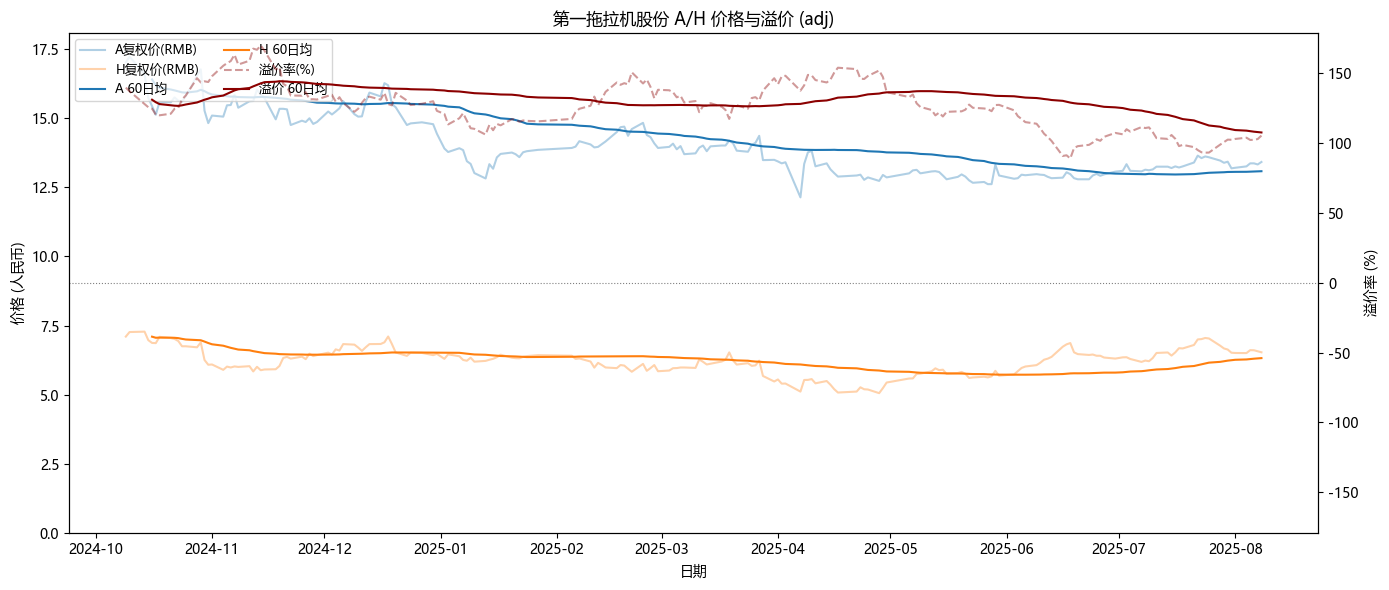

In [8]:
# Section 8: 绘图函数 (价格 + 溢价率)


def plot_price_premium(
    df: pd.DataFrame,
    name: str,
    premium_mode: str = "adj",
    roll_window: int = 60,
    save: bool = False,
    out_path: Optional[str] = None,
):
    if df.empty:
        raise ValueError("空数据")
    if premium_mode not in {"adj", "raw"}:
        raise ValueError("premium_mode 必须为 adj/raw")
    df = df.sort_values("trade_date")
    col = f"premium_pct_{premium_mode}"
    if col not in df.columns:
        raise ValueError("缺少列:" + col)
    # 添加滚动列供展示
    df_plot = add_rolling_features(df, col=col, win=roll_window)
    t = pd.to_datetime(df_plot["trade_date"])
    fig, ax_price = plt.subplots(figsize=(14, 6))
    ax_price.plot(
        t, df_plot["a_adj"], label="A复权价(RMB)", color="tab:blue", alpha=0.35
    )
    ax_price.plot(
        t, df_plot["h_adj_cny"], label="H复权价(RMB)", color="tab:orange", alpha=0.35
    )
    ax_price.plot(
        t,
        df_plot["a_adj_roll_" + str(roll_window)],
        label=f"A {roll_window}日均",
        color="tab:blue",
    )
    ax_price.plot(
        t,
        df_plot["h_adj_cny_roll_" + str(roll_window)],
        label=f"H {roll_window}日均",
        color="tab:orange",
    )
    ax_price.set_ylabel("价格 (人民币)")
    ax_price.set_ylim(0, df_plot[["a_adj", "h_adj_cny"]].max().max() * 1.05)

    ax_prem = ax_price.twinx()
    prem = df_plot[col]
    ax_prem.plot(t, prem, "--", color="darkred", alpha=0.4, label="溢价率(%)")
    ax_prem.plot(
        t, df_plot[col + "_roll_mean"], color="darkred", label=f"溢价 {roll_window}日均"
    )
    ax_prem.axhline(0, color="gray", linewidth=0.8, linestyle=":")
    prem_max = math.ceil(abs(prem).max() * 1.05)
    ax_prem.set_ylim(-prem_max, prem_max)
    ax_prem.set_ylabel("溢价率 (%)")

    # 合并图例
    h1, l1 = ax_price.get_legend_handles_labels()
    h2, l2 = ax_prem.get_legend_handles_labels()
    ax_price.legend(h1 + h2, l1 + l2, loc="upper left", fontsize=9, ncol=2)
    ax_price.set_title(f"{name} A/H 价格与溢价 ({premium_mode})")
    ax_price.set_xlabel("日期")
    fig.tight_layout()
    if save:
        if out_path is None:
            out_path = f"{name}_price_premium_{premium_mode}.png"
        fig.savefig(out_path, dpi=160)
    plt.show()


# 快速演示（若可）
_demo_name = next(iter(NAME2CODES.keys()))
_demo_df = add_premium(load_pair_history(_demo_name))
if not _demo_df.empty:
    plot_price_premium(_demo_df.tail(200), _demo_name)

==== 中国人寿 ====
[FX] 缺失汇率 <= 20120104
[FX] 缺失汇率 <= 20120105
[FX] 缺失汇率 <= 20120106
[FX] 缺失汇率 <= 20120109
[FX] 缺失汇率 <= 20120110
[FX] 缺失汇率 <= 20120111
[FX] 缺失汇率 <= 20120112
[FX] 缺失汇率 <= 20120113
[FX] 缺失汇率 <= 20120116
[FX] 缺失汇率 <= 20120110
[FX] 缺失汇率 <= 20120111
[FX] 缺失汇率 <= 20120112
[FX] 缺失汇率 <= 20120113
[FX] 缺失汇率 <= 20120116
[FX] 缺失汇率 <= 20120117
[FX] 缺失汇率 <= 20120118
[FX] 缺失汇率 <= 20120119
[FX] 缺失汇率 <= 20120120
[FX] 缺失汇率 <= 20120130
[FX] 缺失汇率 <= 20120131
[FX] 缺失汇率 <= 20120117
[FX] 缺失汇率 <= 20120118
[FX] 缺失汇率 <= 20120119
[FX] 缺失汇率 <= 20120120
[FX] 缺失汇率 <= 20120130
[FX] 缺失汇率 <= 20120131
[FX] 缺失汇率 <= 20120201
[FX] 缺失汇率 <= 20120202
[FX] 缺失汇率 <= 20120203
[FX] 缺失汇率 <= 20120206
[FX] 缺失汇率 <= 20120207
[FX] 缺失汇率 <= 20120208
[FX] 缺失汇率 <= 20120201
[FX] 缺失汇率 <= 20120202
[FX] 缺失汇率 <= 20120203
[FX] 缺失汇率 <= 20120206
[FX] 缺失汇率 <= 20120207
[FX] 缺失汇率 <= 20120208
[FX] 缺失汇率 <= 20120209
[FX] 缺失汇率 <= 20120210
[FX] 缺失汇率 <= 20120213
[FX] 缺失汇率 <= 20120214
[FX] 缺失汇率 <= 20120215
[FX] 缺失汇率 <= 20120216
[FX] 缺失汇率 <= 2012

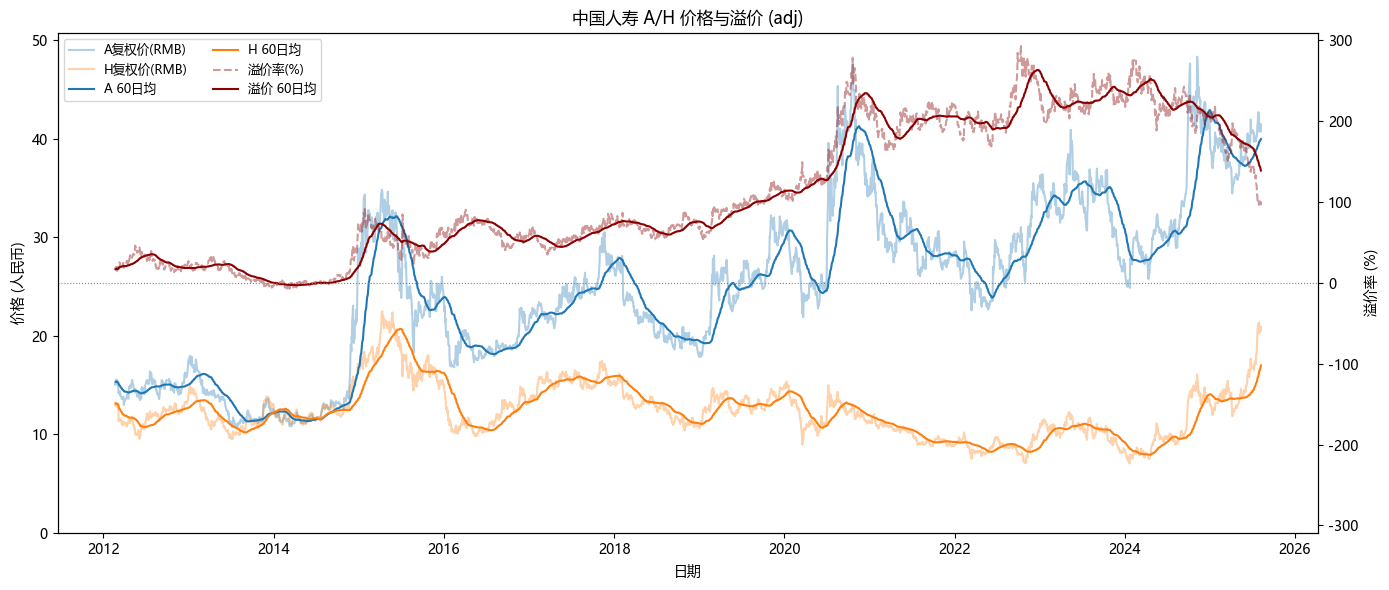

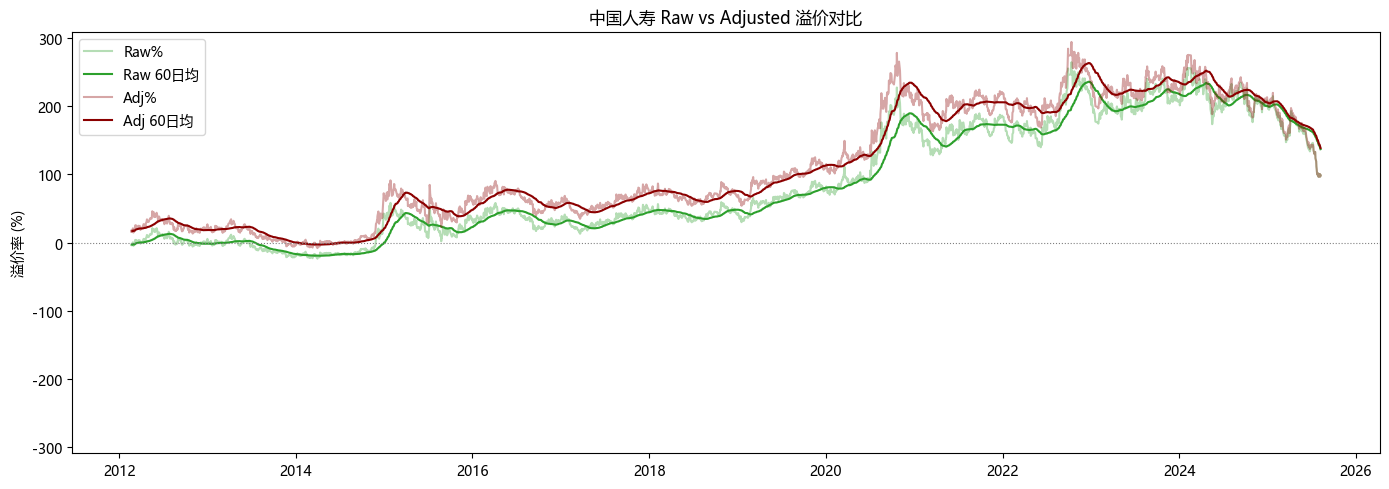

==== 招商银行 ====


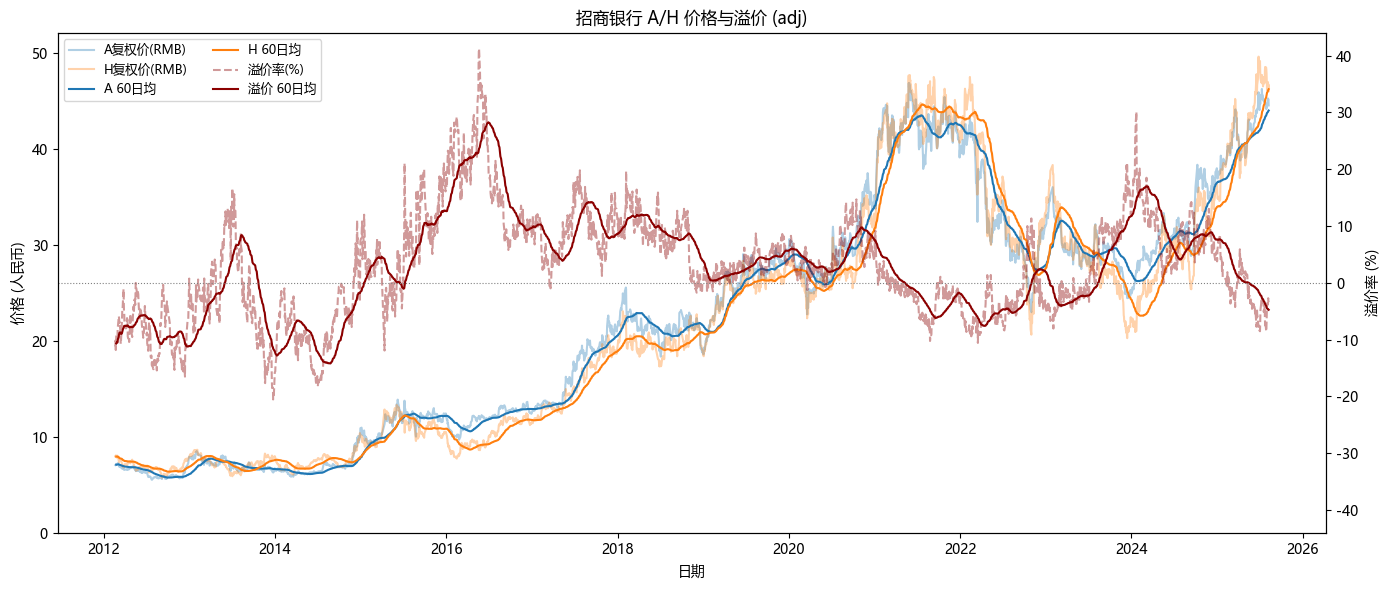

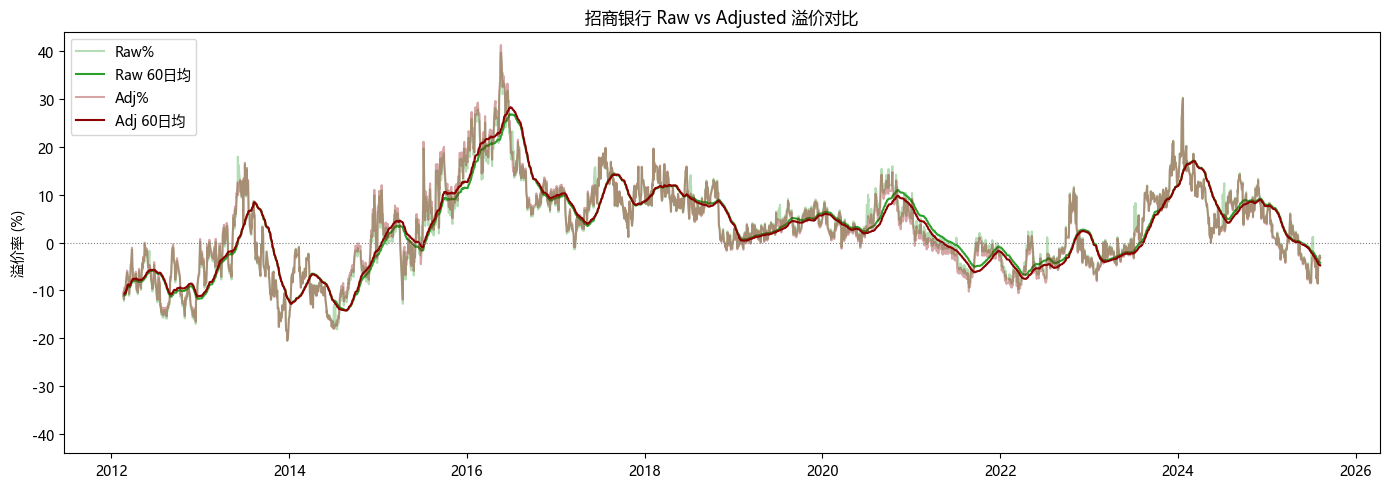

==== 宁德时代 ====


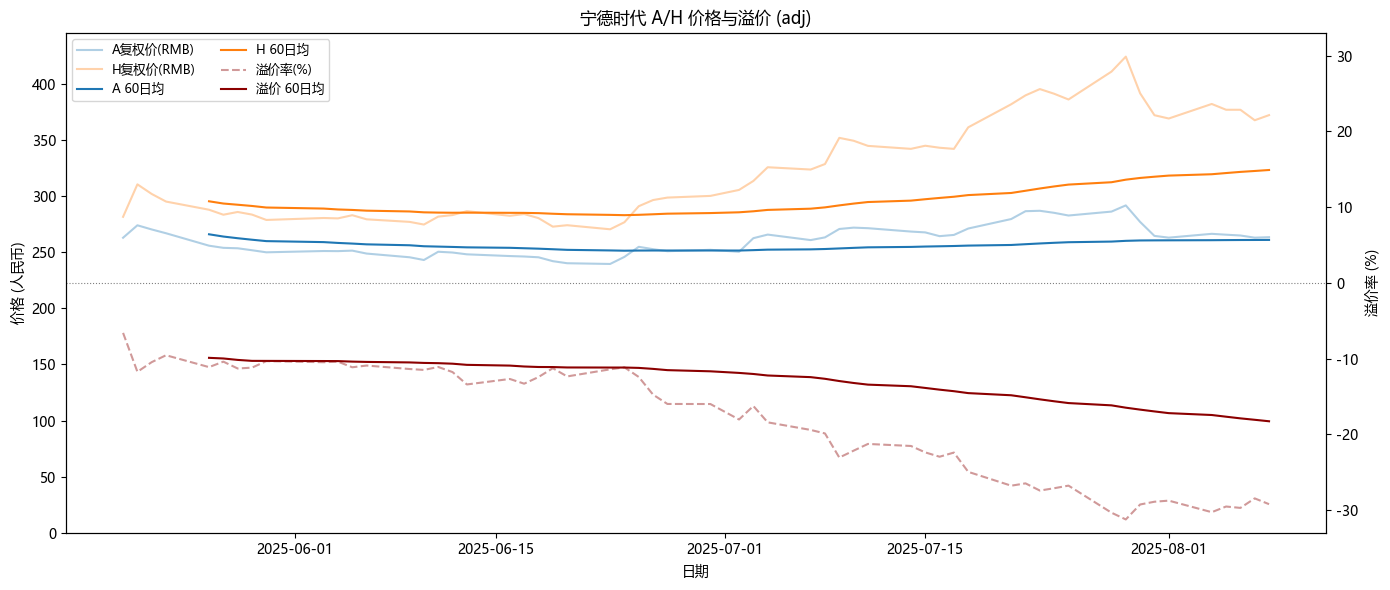

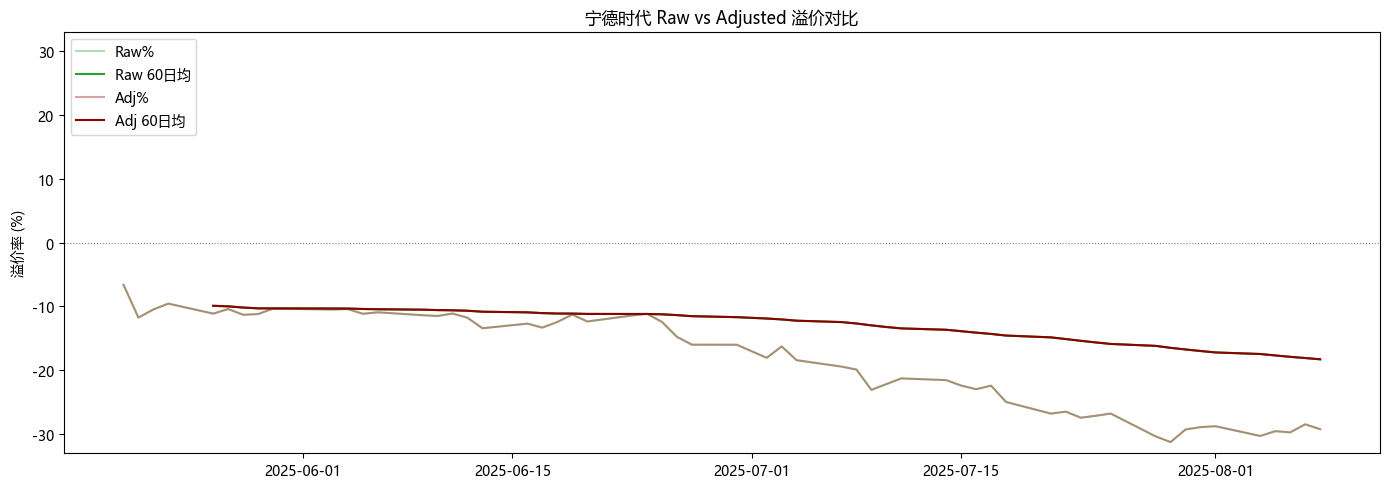

==== 中信证券 ====


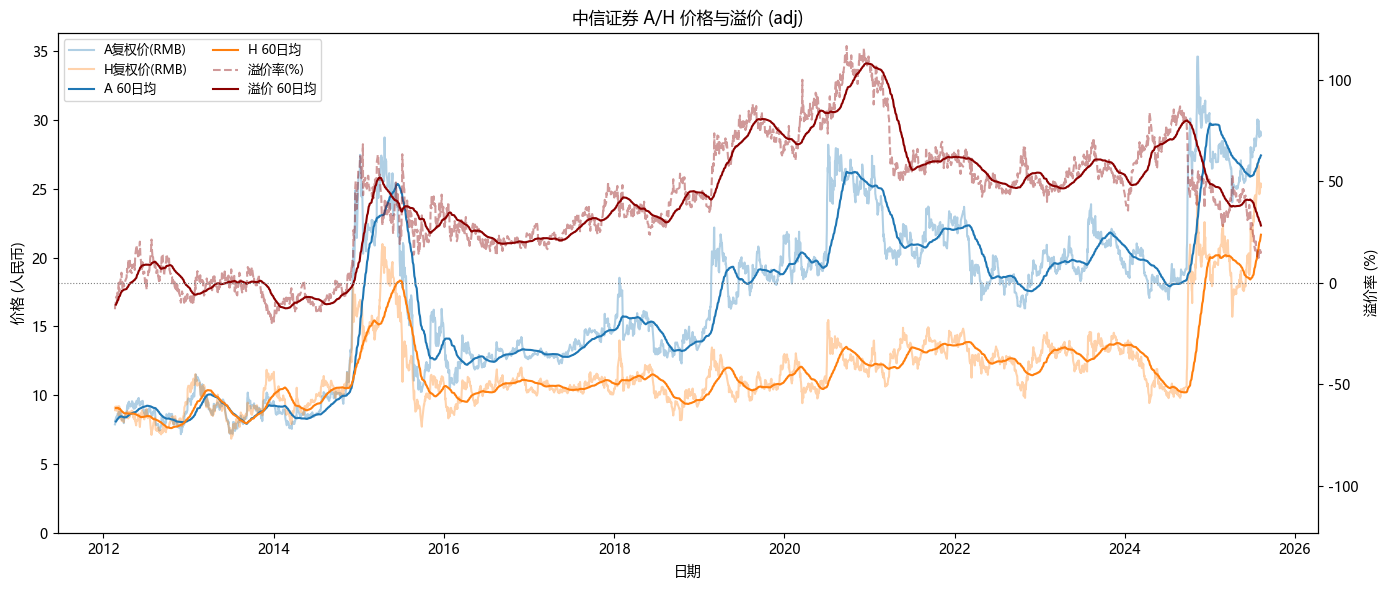

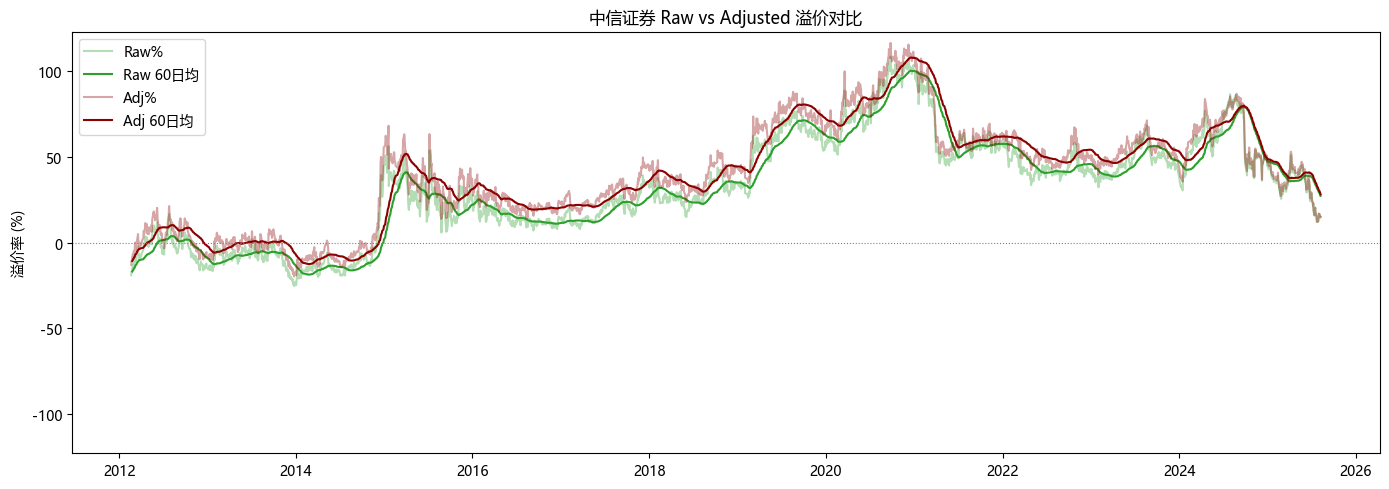

==== 中国平安 ====


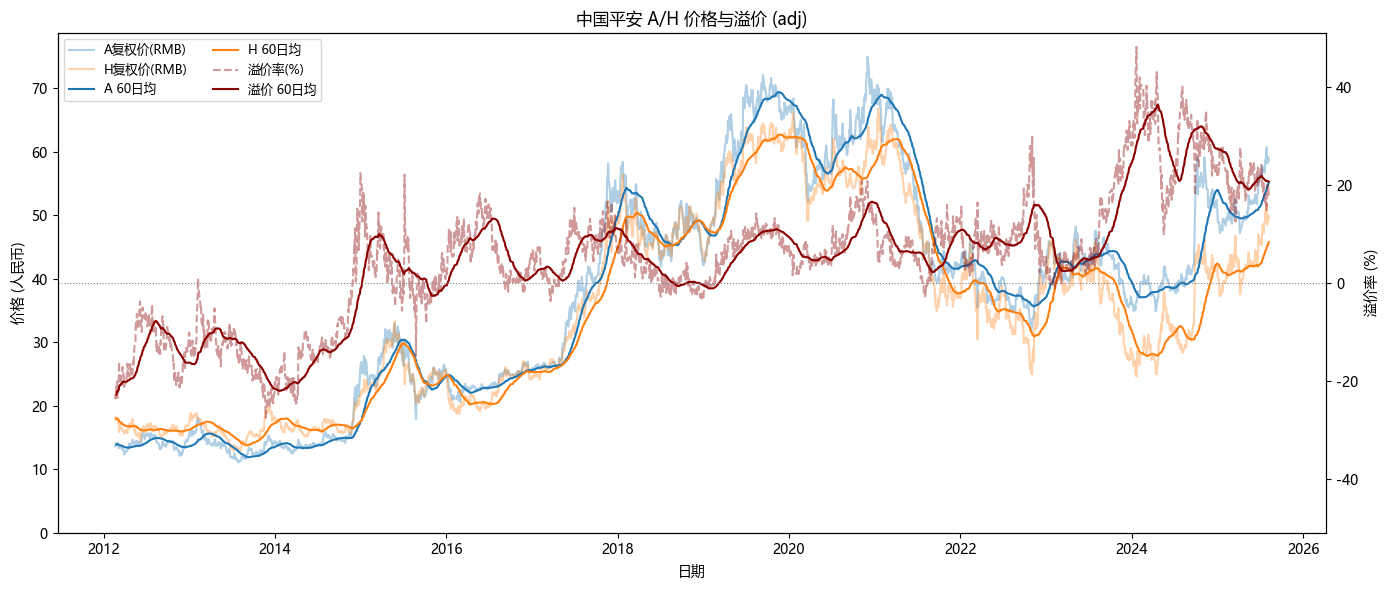

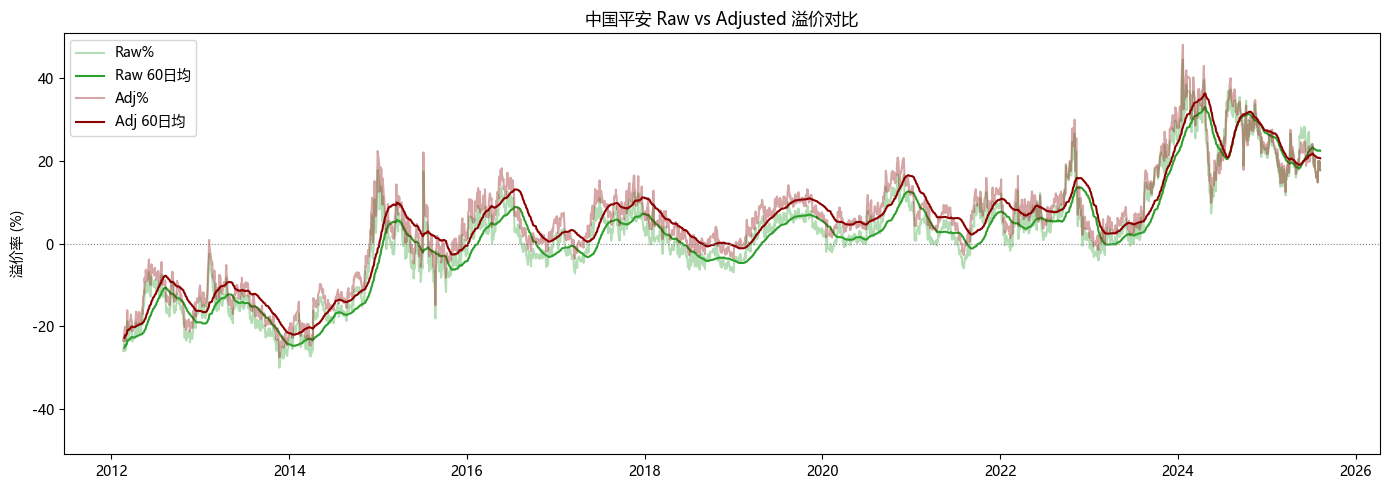

==== 中金公司 ====


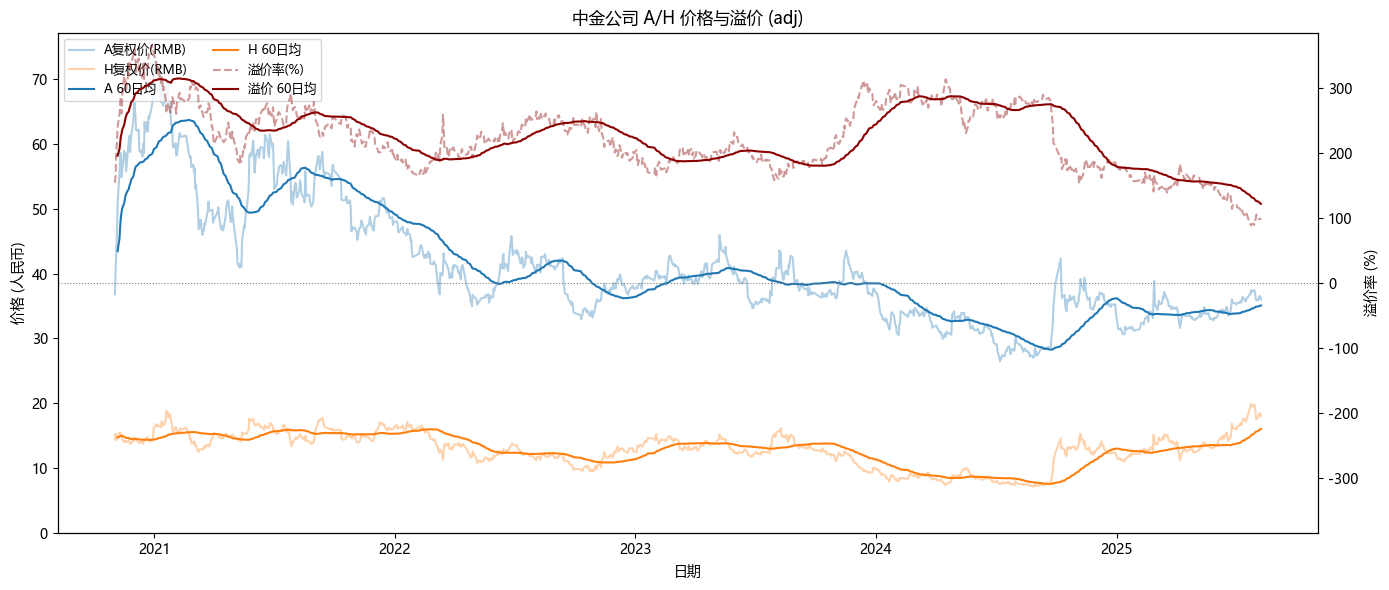

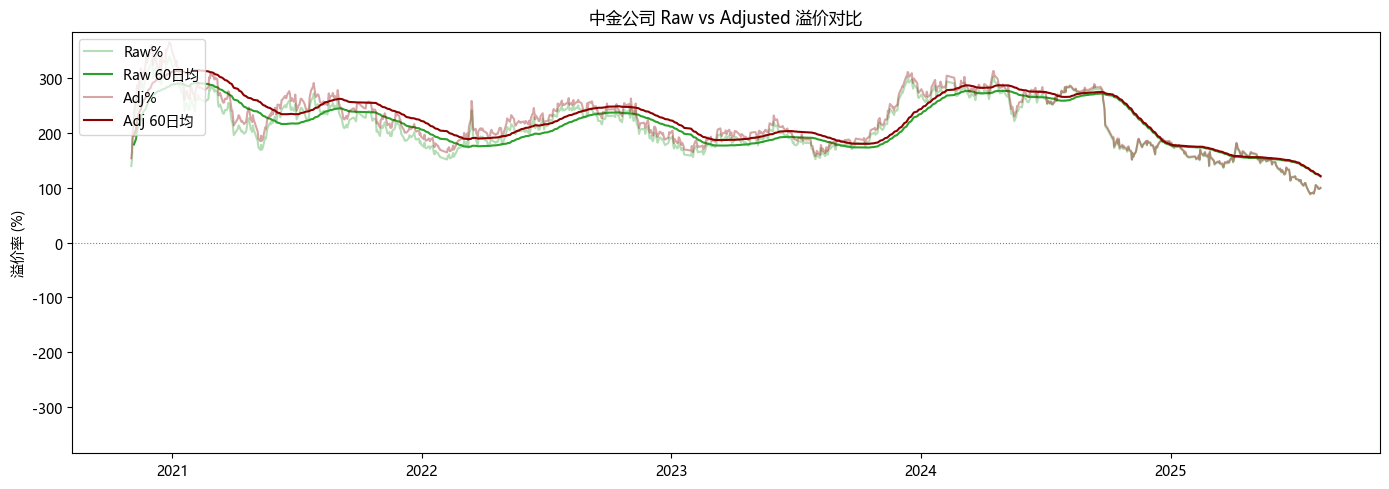

==== 中国银行 ====


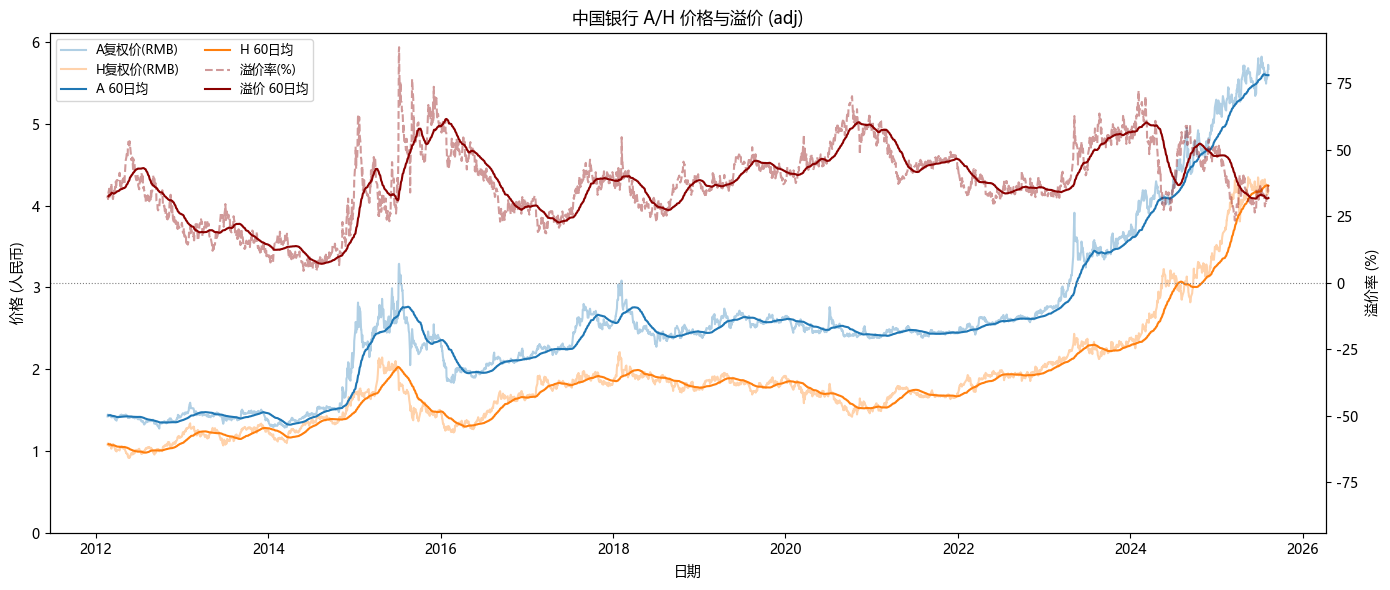

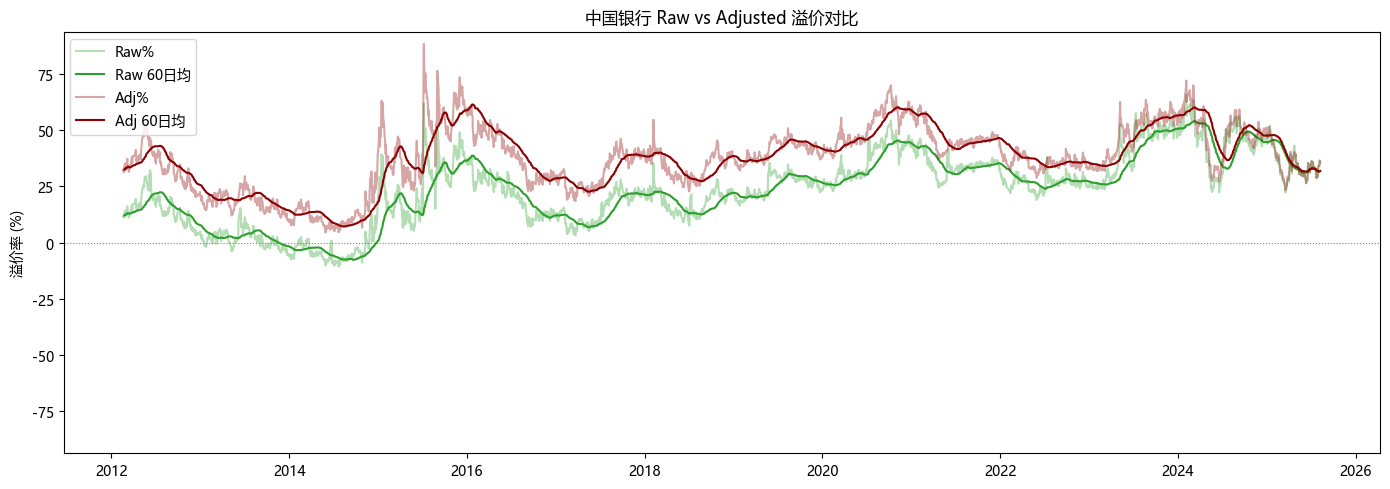

In [13]:
# 绘制 中国人寿、招商银行、宁德时代、中信证券、中国平安、中金公司、中国银行 的图
stocks_to_plot = [
    "中国人寿",
    "招商银行",
    "宁德时代",
    "中信证券",
    "中国平安",
    "中金公司",
    "中国银行",
]

ROLL = 60  # 可调整
for nm in stocks_to_plot:
    print("====", nm, "====")
    if nm not in NAME2CODES:
        print("  未在配对表中, 跳过")
        continue
    df_nm = add_premium(load_pair_history(nm))
    if df_nm.empty:
        print("  数据为空, 跳过")
        continue
    # 完整绘制（复权价 + 溢价）
    plot_price_premium(df_nm, nm, premium_mode="adj", roll_window=ROLL)
    # Raw vs Adjusted 对比
    plot_premium_compare(df_nm, nm, roll_window=ROLL)

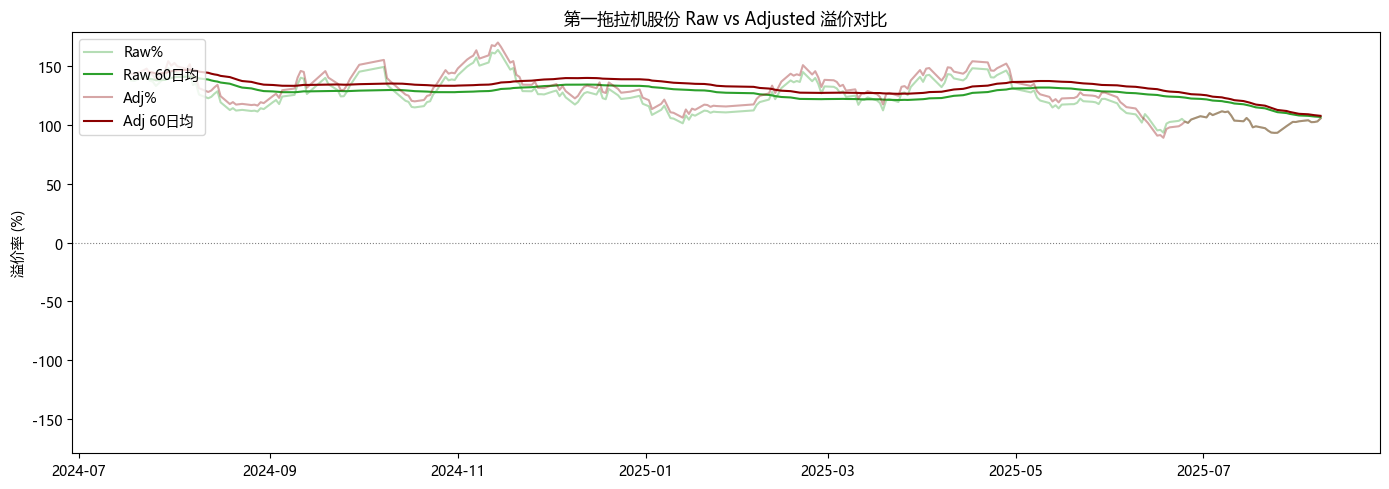

In [9]:
# Section 9: raw vs adjusted 溢价对比


def plot_premium_compare(df: pd.DataFrame, name: str, roll_window: int = 60):
    if df.empty:
        raise ValueError("空数据")
    df = df.sort_values("trade_date")
    df2 = add_rolling_features(
        add_rolling_features(df, col="premium_pct_raw", win=roll_window),
        col="premium_pct_adj",
        win=roll_window,
    )
    t = pd.to_datetime(df2["trade_date"])
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(t, df2["premium_pct_raw"], color="tab:green", alpha=0.35, label="Raw%")
    ax.plot(
        t,
        df2["premium_pct_raw_roll_mean"],
        color="tab:green",
        label=f"Raw {roll_window}日均",
    )
    ax.plot(t, df2["premium_pct_adj"], color="darkred", alpha=0.35, label="Adj%")
    ax.plot(
        t,
        df2["premium_pct_adj_roll_mean"],
        color="darkred",
        label=f"Adj {roll_window}日均",
    )
    ax.axhline(0, color="gray", linestyle=":", linewidth=0.8)
    m = math.ceil(
        max(abs(df2["premium_pct_raw"]).max(), abs(df2["premium_pct_adj"]).max()) * 1.05
    )
    ax.set_ylim(-m, m)
    ax.set_ylabel("溢价率 (%)")
    ax.set_title(f"{name} Raw vs Adjusted 溢价对比")
    ax.legend(loc="upper left")
    fig.tight_layout()
    plt.show()


if not _demo_df.empty:
    plot_premium_compare(_demo_df.tail(250), _demo_name)